In [1]:
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
class AbstractDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        abstract = self.df.iloc[idx]["text_lg"]
        topic = self.df.iloc[idx]["topic_int"]
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(topic, dtype=torch.long),
        }

test_df = pd.read_csv("test_scibert.csv")

# Load the best model after training
model = AutoModelForSequenceClassification.from_pretrained("scibert_model")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Create the test dataset
test_dataset = AbstractDataset(
    df=test_df,
    tokenizer=tokenizer,
    max_length=512,
)

# Create the Trainer object
training_args = TrainingArguments(
    output_dir='./results',  # output directory
    per_device_eval_batch_size=8,  # batch size for evaluation
)
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
)

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# In[ ]:

def get_predictions(model, tokenizer, dataset):
    predictions = []
    for item in dataset:
        input_ids = item["input_ids"].unsqueeze(0).to(model.device)
        attention_mask = item["attention_mask"].unsqueeze(0).to(model.device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = logits.argmax(dim=1).item()
        predictions.append(predicted_label)
    return predictions


y_true = test_df["topic_int"].tolist()
y_pred = get_predictions(model, tokenizer, test_dataset)

print(classification_report(y_true, y_pred))



              precision    recall  f1-score   support

           0       0.99      0.96      0.97       250
           1       0.98      0.99      0.99       876
           2       0.98      0.98      0.98      1133
           3       0.96      0.99      0.97       204
           4       0.98      0.97      0.98       755
           5       0.97      0.98      0.98       686
           6       0.97      0.99      0.98       374

    accuracy                           0.98      4278
   macro avg       0.98      0.98      0.98      4278
weighted avg       0.98      0.98      0.98      4278



In [ ]:
0 -> Long Covid
1 -> Treatment
2 -> Prevention
3 -> Epidemic Forecasting
4 -> Diagnosis
5 -> Case Report
6 -> Mechanism

In [9]:
mapping = {0: 2, 1: 4, 2: 5, 3: 1, 4: 6, 5: 0, 6: 3}

y_true_mapped = [mapping[val] for val in y_true]
y_pred_mapped = [mapping[val] for val in y_pred]

SciBERT Confusion Matrix:


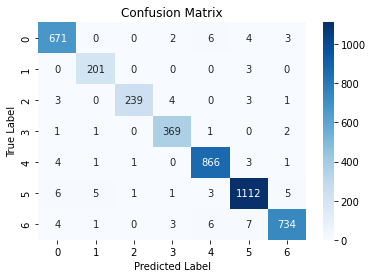

In [10]:
cm_bert = confusion_matrix(y_true_mapped, y_pred_mapped)
print("SciBERT Confusion Matrix:")

# visualize the confusion matrix
sns.heatmap(cm_bert, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [4]:
test_df['bert_preds'] = y_pred

In [5]:
test_df.loc[:, 'pmid':].to_csv("LitCovid_scibert.csv")

In [6]:
test_df.loc[:, 'pmid':]

,pmid,text_lg,topic,topic_int,bert_preds
0,35949757,mucormycosis opportunistic fungal infection ca...,Case Report,5,5
1,36610390,nasal mucosa important initial site host defen...,Treatment,1,1
2,35148261,objective modification common ribonucleic acid...,Mechanism,6,6
3,32925503,oligosymptomatic patient initially exclusively...,Case Report,5,5
4,35690403,model propose increase access home dialysis tr...,Prevention,2,2
...,...,...,...,...,...
4273,33871421,purpose review despite significant progress un...,Long Covid,0,0
4274,32804803,background coronavirus disease covid-19 pandem...,Prevention,2,2
4275,36002399,people survive covid-19 experience negative pe...,Long Covid,0,0
4276,35252760,deadly novel coronavirus sars-cov-2 responsibl...,Diagnosis,4,4


In [7]:
mask = test_df['topic_int'] != test_df['bert_preds']
wrong_df = test_df[mask].loc[:, 'pmid':]

In [8]:
wrong_df

,pmid,text_lg,topic,topic_int,bert_preds
84,32791519,abstract coronavirus 2019 covid-19 pandemic di...,Case Report,5,2
96,32879033,objective aim measure severe acute respiratory...,Long Covid,0,4
103,34019443,rheumatology 23/answers rheumatoid arthritis f...,Long Covid,0,5
186,32607555,abstract background remdesivir prodrug nucleos...,Case Report,5,1
212,34661382,beginning sars-cov-2 epidemic virus isolation ...,Diagnosis,4,6
...,...,...,...,...,...
4218,36951276,background despite million covid-19 case unite...,Diagnosis,4,1
4224,36556121,covid-19 pandemic face healthcare landscape ch...,Diagnosis,4,2
4242,35711278,purpose vaccination essential control prevalen...,Prevention,2,1
4244,33039259,article withdraw request author(s and/or edito...,Prevention,2,6
